# Implied Vol Surface
Visualize the implied vol surface for Local Volatility, rBergomi, and the Heston model. The intention of this notebook is to confirm that all the models can reproduce prices of vanilla options (exceptions noted), using the calibrated parameters. In the other notebooks we will examine different exotic payoffs.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from qablet.base.flags import Stats

from data.spx_2005_09_15 import (
    rbergomi_data,
    heston_data,
    localvol_data,
    basic_info,
)
from qablet.heston.mc import HestonMCModel
from qablet.black_scholes.mc import LVMCModel
from src.model.rbergomi import rBergomiMCModel
from src.model.utils.qablet_utils import iv_surface
from src.model.utils.svi import svi

### Methodology
We will compare volatility smiles for a number of expirations. We will also compare the term structure of atm volatilities.

In [2]:
# We will compare everything with the SVI implied volatilities on 2005-09-15
info = basic_info()
prc_dt = info["prc_dt"]
ticker = info["ticker"]
spot = info["spot"]

svi_df = pd.read_csv("data/spx_svi_2005_09_15.csv", parse_dates=["date"])
expirations = list(svi_df["date"][1:-2])  # Skip the last two expirations

logK = np.arange(-0.25, 0.1, 0.01)
atm_idx = 25

Instead of calling `model.price` for each option separately, we will use the utility `iv_surface` in `model.utils.qablet_utils`



### Local Vol Surface

In [3]:
model = LVMCModel()
dataset = localvol_data()
dataset["MC"]["FLAGS"] = Stats.CASHFLOW

localvol_iv = iv_surface("SPX", model, dataset, logK, expirations)

### Bergomi Vol Surface

In [4]:
model = rBergomiMCModel()
dataset = rbergomi_data()
dataset["MC"]["FLAGS"] = Stats.CASHFLOW

bergomi_iv = iv_surface("SPX", model, dataset, logK, expirations)

### Heston Vol Surface

In [5]:
model = HestonMCModel()
dataset = heston_data()
dataset["MC"]["FLAGS"] = Stats.CASHFLOW

heston_iv = iv_surface("SPX", model, dataset, logK, expirations)

### The Implied Vol Surface (SVI)

In [6]:
svi_iv = np.zeros((len(expirations), len(logK)))
for i, exp in enumerate(expirations):
    params = svi_df[svi_df["date"] == exp].iloc[0]
    w = svi(params, logK)
    svi_iv[i] = np.sqrt(w / params["texp"])

### Plot Each Expiration Smile

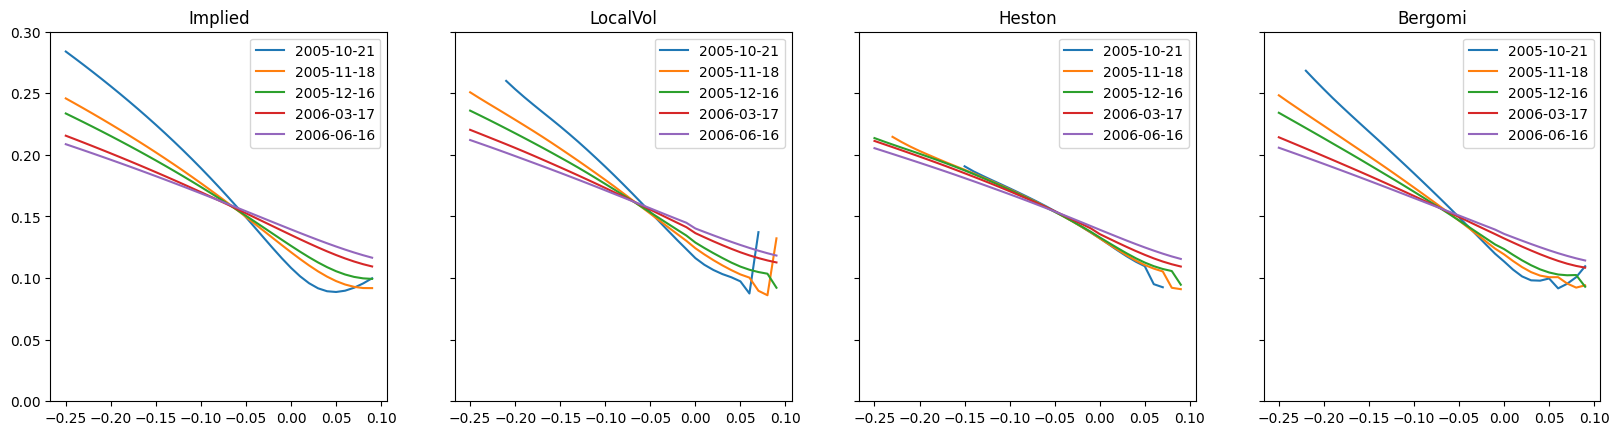

In [7]:
ivs = [svi_iv, localvol_iv, heston_iv, bergomi_iv]
models = ["Implied", "LocalVol", "Heston", "Bergomi"]

fig, axes = plt.subplots(1, 4, sharey=True)
fig.set_figwidth(20)

for ax, iv, label in zip(axes, ivs, models):
    for i, exp in enumerate(expirations):
        ax.plot(logK, iv[i, :], label=exp.strftime("%Y-%m-%d"))
        ax.legend()
        ax.set_title(label)
        ax.set_ylim(0, 0.3)

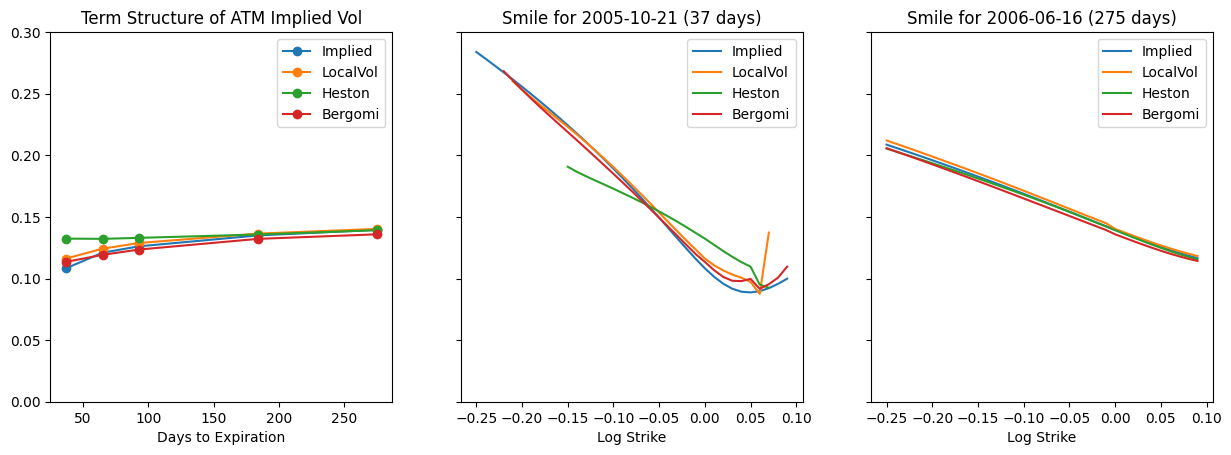

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(15)

# First Plot: ATM IV by Expiration
for iv, label in zip(ivs, models):
    ax1.plot(
        [(exp - prc_dt).days for exp in expirations],
        iv[:, atm_idx],
        label=label,
        marker="o",
    )
ax1.set_xlabel("Days to Expiration")
ax1.set_title("Term Structure of ATM Implied Vol")
ax1.legend()


# Second, Third Plot: The nearest and farthest slice for all models
for exp_idx, ax in zip([0, -1], [ax2, ax3]):
    for iv, label in zip(ivs, models):
        ax.plot(logK, iv[exp_idx, :], label=label)
        term_str = expirations[exp_idx].strftime("%Y-%m-%d")
        days = (expirations[exp_idx] - prc_dt).days
        ax.set_title(f"Smile for {term_str} ({days} days)")
        ax.set_ylim(0.0, 0.30)
        ax.set_xlabel("Log Strike")
ax2.legend()
ax3.legend()

TODO: replace the classical Heston model by one with a term structure, otherwise it struggles to match the near term vols.